# Sparkify Project Workspace

You will first define the problem you want to solve and investigate potential solutions.

Next, you will analyze the problem through visualizations and data exploration to have a better understanding of what algorithms and features are appropriate for solving it.

You will then implement the algorithms and metrics of your choice, documenting the preprocessing, refinement, and post-processing steps along the way.

Afterwards, you will collect results about your findings, visualize significant quantities, validate/justify your results, and make any concluding remarks about whether your implementation adequately solves the problem.

Finally, you will construct a blog post (or other medium for a write-up) to document all of the steps from start to finish of your project, or deploy your results into a web application.

In [1]:
# Load In Library
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, \
isnan, when, count, col, countDistinct, from_unixtime, year, month, dayofmonth
from pyspark.sql.types import IntegerType, DateType, StringType

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import seaborn as sns

import re

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Project Definition
### Project Overview
The purpose of this study is to predict the next action of users so that company can take actions to aviod clients to leave us or downgrade from paid users to unpaid users. The meaning of this project can help companies to keep the revenue status.

### Problem Statement
The key problem we are facing here is to use the users activities to predict their next big steps, such as leaving us. We as an analyst would need to use historical log records to find out the pattern that users leaving us normally have and using those features to define the protential of a specific user to leave us.

### Metrics
Metrics used to measure performance of our model is based on the prediction accuracy. To be more specific F1 Score, which is a combination of both precision and recall.

# Load and Clean Dataset

In [3]:
# Loadin Datasets
evt_data = 'mini_sparkify_event_data.json'
df = spark.read.json(evt_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
# Clean Datasets
# 1. Print out Schema to have a general idea about the columns included
df.printSchema()

# 2. Check the missing info status, records without userids, or sessionids.
# As per result showned below, there are two types of missing amount. One has 58392 missing rows and the other has 8346
# missing rows. The 8346 empty rows are baseically because the users are not registered and we are not able to gather information 
# because of that.
for column in df.columns:
    v = df.where(col(column).isNull()).count()
    print("{} has {} empty rows".format(column, v))

# 3. Check unique values for each columns
[df.select(col).distinct().count() for col in df.columns]

# 4. Fill null gender with 'Not Sure'
df = df.na.fill({'gender': 'Not Sure'})

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

artist has 58392 empty rows
auth has 0 empty rows
firstName has 8346 empty rows
gender has 8346 empty rows
itemInSession has 0 empty rows
lastName has 8346 empty rows
length has 58392 empty rows
level has 0 empty rows
location has 8346 empty rows
method has 0 empty rows
page has 0 empty rows
registration

# Exploratory Data Analysis

### Define Churn

This study would use and track `Cancellation Confirmation` events as the indicator of `Churn`.

### Explore Data

Additional study regarding the churn activities is explorated below by comparing the num of song listened by users. 
In the page column, we can notice there is one option called "Cancellation Confirmation". This means we have completely lose this client. For the test datasets, we find there are 52 users accounts that cancelled our services, which takes account for 23% of the total user ids.

In [5]:
# 1. Take a look at the unique values of columns to generate ideas of the raw data
cols_to_check = ['auth', 'gender', 'level', 'page', 'registration', 'ts', 'userId']
for column in cols_to_check:
    v = df.select(column).distinct().rdd.map(lambda r: r[0]).collect()
    print("{} has values of {}".format(column, v))

auth has values of ['Logged Out', 'Cancelled', 'Guest', 'Logged In']
gender has values of ['F', 'M', 'Not Sure']
level has values of ['free', 'paid']
page has values of ['Cancel', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'Cancellation Confirmation', 'About', 'Submit Registration', 'Settings', 'Login', 'Register', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']
registration has values of [1529027541000, 1533192032000, 1537779419000, 1534627466000, 1535389443000, 1536642109000, 1537167593000, 1536854322000, 1533908361000, 1536817381000, 1536663902000, 1537672236000, 1536956945000, 1537611935000, 1537751138000, 1533532298000, 1537057938000, 1537964483000, 1528772084000, 1537440271000, 1536303841000, 1534768517000, 1537484200000, 1538050164000, 1532450666000, 1536032681000, 1534461078000, 1538331630000, 1536102943000, 1536831228000, 1535623466000, 1537306307000, 1537522781000, 1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



userId has values of ['100010', '200002', '125', '51', '124', '7', '54', '15', '155', '132', '154', '100014', '101', '11', '138', '300017', '29', '69', '100021', '42', '112', '87', '73', '64', '200010', '3', '30', '113', '34', '133', '59', '146', '139', '8', '28', '22', '300018', '300012', '100022', '85', '52', '35', '16', '300008', '71', '98', '300013', '99', '47', '100008', '100025', '110', '107', '300006', '300002', '96', '43', '300007', '5', '100', '100006', '18', '70', '100005', '27', '61', '75', '131', '126', '140', '17', '26', '100007', '120', '200007', '46', '300004', '147', '300001', '78', '300015', '77', '89', '136', '6', '118', '300019', '200014', '100009', '300011', '90', '104', '68', '60', '100004', '200003', '100015', '19', '300023', '300024', '41', '128', '23', '200024', '102', '55', '200008', '111', '100016', '100003', '95', '93', '40', '38', '103', '200005', '25', '200009', '135', '44', '156', '144', '100024', '115', '82', '200023', '53', '92', '122', '117', '108', '30

In [6]:
# 2. User Cancellsation Analysis
# Take a look at those users with page activities include Cancellation Confirmation
df.where('auth="Cancelled"').select('userId').distinct().count()

# Take a look at the total users pool
cel_pct = df.where('auth="Cancelled"').select('userId').distinct().count()/df.select('userId').distinct().count()

In [7]:
# 3. Define Churn Columns
flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_churn = df.withColumn("Churn", flag_cancel_event("page"))

In [8]:
# 4. Check the status of Churned Users to verify if the same user has two option, namely 1 and 0 for Churn columns
churned_user_li = df_churn.groupBy('userId').agg(countDistinct("Churn").alias("Count_Churn")).where('Count_Churn=2').select('userId').collect()
churned_user = [r['userId'] for r in churned_user_li]

In [9]:
# 5. Differentiate Users in terms of if they have churned
flag_calcel_user = udf(lambda x: "Lost Client" if x in churned_user else "Client", StringType())
df_churn = df.withColumn("Churn User", flag_calcel_user("userId"))

In [10]:
# 6. Use timestamp column to create date
df_churn = df_churn.withColumn('Date', from_unixtime(df_churn.ts/1000))
df_churn = df_churn.withColumn('Year', year(df_churn.Date))
df_churn = df_churn.withColumn('Month', month(df_churn.Date))
df_churn = df_churn.withColumn('Days', dayofmonth(df_churn.Date))

In [11]:
# 7. Groupby Result to show the data logic
# Check the played song number and the relationship with time
# As per 1st stage observation, all the data is for Year 2018 and there are only few rows for November and December.
df_song_user = df_churn.filter('page="NextSong"').filter('Month ==10')
df_song_count = df_song_user.groupBy('Churn User', 'Days', 'page').agg(count('song').alias("Total Song Played")).toPandas()

# Order Groupby Result
df_song_count = df_song_count.sort_values(['Churn User', 'Days'])

# 8. Get number of users by group
df_unique_users = df_song_user.groupBy('Churn User').agg(countDistinct('userID').alias('Unique Users')).toPandas()

# 9. Get Average Songs Per User
lost_num = df_unique_users[df_unique_users['Churn User'] == "Lost Client"]['Unique Users'].values[0]
exist_num = df_unique_users[df_unique_users['Churn User'] == "Client"]['Unique Users'].values[0]
df_song_count['Song Per User'] = df_song_count.apply(lambda x: int(x['Total Song Played']/exist_num) if x['Churn User'] == "Lost Client" else int(x['Total Song Played']/lost_num), axis = 1)

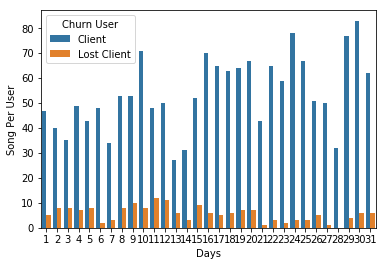

In [12]:
# 10. Use groupby result to create visualizations
ax = sns.barplot(x="Days", y="Song Per User", hue="Churn User", data=df_song_count)

# Feature Engineering
Those columns: 'gender', 'page', 'ts', 'userId', 'level' are used as the based parameters to predict the lost of clients. 

In [13]:
# Feature Extraction
# 1. Define related features required from the original dataset
cols = ['gender', 'page', 'ts', 'userId', 'level']

# 2. Extract Required Features
def feature_extract(df):
    # 1. Select Required Columns
    df = df.select(cols)
    
    # 2. Add Additional Columns
    # 2.1 Define Churn Columns
    flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df_churn = df.withColumn("Churn", flag_cancel_event("page"))
    
    # 2.2 Check the status of Churned Users to verify if the same user has two option, namely 1 and 0 for Churn columns
    churned_user_li = df_churn.groupBy('userId').agg(countDistinct("Churn").alias("Count_Churn")).where('Count_Churn=2').select('userId').collect()
    churned_user = [r['userId'] for r in churned_user_li]
    
    # 2.3 Differentiate Users in terms of if they have churned
    flag_calcel_user = udf(lambda x: "Lost Client" if x in churned_user else "Client", StringType())
    df_churn = df.withColumn("Churn User", flag_calcel_user("userId"))
    
    # 2.4 Time Stamps to Date
    df_churn = df_churn.withColumn('Date', from_unixtime(df_churn.ts/1000))
    df_churn = df_churn.withColumn('Year', year(df_churn.Date))
    df_churn = df_churn.withColumn('Month', month(df_churn.Date))
    df_churn = df_churn.withColumn('Days', dayofmonth(df_churn.Date))
    
    # 3. Output Modelling related columns
    df_model = df_churn.select('gender', 'page', 'Churn User','level', 'userId', 'Year', 'Month', 'Days')
    
    return df_model

In [14]:
df_new = feature_extract(df)

# Modeling
A model function is created, which help to split dataset, build model pipeline, as well as tuning the model

In [15]:
def model(df):
    # 1. Split Train & Test Data
    rest, validation = df.randomSplit([0.8, 0.2], seed=42)
    
    # 2. Build Model Pipeline
    # Index labels, adding metadata to the label column.
    # Fit on whole dataset to include all labels in index.
    genderIndexer = StringIndexer(inputCol="gender", outputCol="indexed_gender")
    levelIndexer = StringIndexer(inputCol="level", outputCol="indexed_level")
    churnIndexer = StringIndexer(inputCol="Churn User", outputCol="indexed_churn_user")


    # One Hot Encoder on indexed features
    genderEncoder = OneHotEncoder(inputCol="indexed_gender", outputCol="gender_vec")
    levelEncoder = OneHotEncoder(inputCol="indexed_level", outputCol="level_vec")
    
    # Create the vector structured data (label,features(vector))
    assembler = VectorAssembler(inputCols=["gender_vec", 'level_vec'], outputCol="features")
    
    # Train the model
    rf = RandomForestClassifier(labelCol="indexed_churn_user", featuresCol="features")
    
    # Chain indexers and forest in a Pipeline
    pipeline = Pipeline(stages=[genderIndexer, levelIndexer, churnIndexer, genderEncoder, \
                                levelEncoder, assembler, rf])
    
    # Cross Validation
    paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[10, 20]) \
    .build()
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(labelCol="indexed_churn_user", metricName="f1"),
                              numFolds=3)
    # Train the model
    cvModel = crossval.fit(rest)

    # Show the model F1 Score on test datasets
    results = cvModel.transform(validation)
    rate = results.filter(results.indexed_churn_user == results.prediction).count()/results.count()
    print('The F1 Score on test dataset is {:.2%}'.format(rate))
    
    return cvModel

In [16]:
model = model(df_new)

The F1 Score on test dataset is 84.55%
